# PT Gradient

An example of how to compute the derivative of an objective function $Z=Z(\rho_f)$ of the final state with respect to a set of system parameters or 'controls' using the OQuPy package. A more detailed explanation of the method can be found in the supplement [Butler2023] (https://arxiv.org/abs/2303.16002).
* [launch binder](https://mybinder.org/v2/gh/tempoCollaboration/OQuPy/HEAD?labpath=tutorials%2Fpt_gradient.ipynb) 
* [download the jupyter file](https://raw.githubusercontent.com/tempoCollaboration/OQuPy/main/tutorials/pt_gradient.ipynb)
* read through the text below and code along

The following packages are required

In [1]:
import numpy as np
import oqupy
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size' : 14.0, 'lines.linewidth':2.50, 'figure.figsize':(8,6)})

The OQuPy version should be `>=v0.5.0`

In [2]:
oqupy.__version__

'0.4.0'

# Contents 

* [0. Introduction](#introduction)

* [1. Example : Spin Boson Model](#example---spin-boson-model)
    - [1.1 System](#1-system-definition)

    - [1.2 Process Tensor generation](#2-process-tensor-generation)

    - [1.3 Objective Function : The Fidelity](#3-objective-function-the-fidelity)
    
    - [1.4 Adjoint method](#4-adjoint-method)


# Introduction

<a id='introduction'></a>

The goal of this tutorial is to calculate the derivative of some generic objective function $Z(\rho_f)$ which only depends on the value of the final density matrix $\rho_f$. This can be decomposed via the chain rule by noting that the final state depends on the set of $N_t$, $(d_H^2,d_H^2)$-dimensional propagators $\{U_n(t) \}_{i=0,..,N_t-1}$ and each propagator depends on the set of $N$ control parameters at that time $\{c_a (t)\}_{i=0,..,N-1}$. Then, the derivative of the objective function with respect to the control parameter $c_a$ at the $n^\text{th}$ timestep is

$$
\frac{\partial Z}{\partial c_a^n}=\sum_{i,j,k}^{d_{H_S}^2}
\frac{\partial Z}{\partial \rho_f^i}
\frac{\partial\rho_f^i}{\partial U^{jk}_n}
\frac{\partial U^{jk}_n}{\partial c_a^n}.
$$
This expression is depicted diagramatically in Fig S2 of the supplement. The three terms in the product are understood as follows:
1. $\frac{\partial Z}{\partial \rho_f^i}$ : The derivative of the objective function with respect to the final state. This is computed analytically and corresponds to rank-1 tensor in Liouville space.
2. $\frac{\partial\rho_f^i}{\partial U^{jk}_n}$ : The derivative of the final state with respect to the propagator at the $n^{\text{th}}$ time-step. Due to the linearity of our network, this is the same as the diagram for the time-evolution of the initial state after $N_t$ steps with the propagator(s) at the $n^{\text{th}}$ timestep removed. The rank of this tensor depends on the order of the Trotterization of the propagators. PT-TEMPO implements a second-order splitting, such that the tensors are rank-$4$.
3. $\frac{\partial U^{jk}_n}{\partial c_a}$ : The derivative of a propagator at the $n^{\text{th}}$ timestep with respect to control parameter $a$ at the $n^\text{th}$ timestep. Due to the second Trotterization, there are $2 N_t$ half-propagators and therefore $2 N_t$ half-propagator derivatives. These are computed via finite-difference and are of rank-$2$. 

Expression 2. is not calculated directly. Rather, we perform a forward propagation of the initial state $\rho_0$ and back propagation of the target derivative $\frac{\partial Z}{\partial \rho_f^i}$ for $n$ time-steps. The stored tensors are of rank-$2$ with an external 'system' leg which connects to the propagators and an internal 'bond' leg connecting to the PT-MPOs. By joining the bond legs of the appropriate tensors from the forward and back propagations we obtain the rank-$4$ tensor $ \frac{\partial Z}{\partial \rho_f^i}
\frac{\partial\rho_f^i}{\partial U^{jk}_n}$ which, when contracted with the propagator derivatives $\frac{\partial U^{jk}_n}{\partial c_a}$, gives $\frac{\partial Z}{\partial c_a^n}$.

As an example, we model a spin-boson system coupled to an external field and compute the gradient with respect to each parameter.

# Example - Spin Boson Model

### 1. System Definition

We choose the system modelled in the supplement, a spin-boson model representing a quantum-dot driven by a laser pulse. We consider a time-dependent system Hamiltonian 
$$
H_S = h_x(t) \sigma_x + h_z(t) \sigma_z ,
$$
where the parameters $h_i(t)$, $i=x,z$ represent a set of fields controlling the system dynamics. A system of this type is represented by a `ParameterizedSystem` object. This object requires a Callable which returns the Hamiltonian at a given timestep. It encapsulates the system dynamics via calculation of the propagators $U^{ij}$ and propagator derivatives $\frac{\partial U^{ij}_n}{\partial c_a^n}$ using the functions `get_propagators` and `get_propagator_derivatives` respectively.

In [3]:
# function which returns system Hamiltonian for a given timestep given the parameters at that step
def discrete_hamiltonian(hx,hz):
    return hx*oqupy.operators.sigma('x') + hz*oqupy.operators.sigma('z')

# definition of parameterized system
system = oqupy.ParameterizedSystem(discrete_hamiltonian)

We then provide a $(2*N_t,N)$-dimensional tuple of parameters which define the value of the fields at each half time-step. For simplicity, we choose a pair of constant fields $h_x=0$ and $h_z=\pi/T$. We choose a pulse duration $T=5 \text{ps}^{-1}$ and model over $100$ timesteps. We work in Planck units throughout ($\hbar = k_B = 1$) and take $\text{ps}^{-1}$ as units of angular momentum.

In [4]:
max_time= 5
num_steps = 100
h_z = np.ones(2*num_steps) * np.pi / (2*max_time)
h_z = h_z.tolist()
h_x = np.zeros(2*num_steps).tolist()

parameters = np.array(list(zip(h_x,h_z)))

### 2. Process Tensor generation

The bath and interaction Hamiltonians are 
$$
H_B = \sum_k \omega_k b_k^\dag b_k 
$$
and 
$$
H_{SB} = \frac{1}{2} \sigma_z \sum_k (g_k b_k^\dag + g^*_k b_k),
$$
respectively. The bath interaction terms $g_k$ and $\omega_k$ are characterised by the super-ohmic spectral density
$$
J(\omega)  = 2 \alpha \omega^3 \omega_c^{-2} \text{exp}(- \frac{\omega^2}{\omega^2_c}).
$$
with $\omega_c=3.04 \text{p s}^{-1}$ and $\alpha=0.126$.
We take the bath to be at $T=5 \text{K}$. The process tensor is then generated as follows.

In [5]:
# spectral density parameters
alpha = 0.126
omega_cutoff = 3.04
temperature = 5 * 0.1309 # 1K = 0.1309/ps in natural units

# numerical tempo parameters
dt = 0.05
dkmax = 60
esprel = 10**(-7)
max_time = 5

correlations = oqupy.PowerLawSD(alpha=alpha,
                                zeta=3,
                                cutoff=omega_cutoff,
                                cutoff_type='gaussian',
                                temperature=temperature)
bath = oqupy.Bath(oqupy.operators.sigma("z")/2, correlations)

tempo_params = oqupy.TempoParameters(dt=dt, dkmax=dkmax, epsrel=esprel)

In [6]:
# process tensor creation
process_tensor = oqupy.pt_tempo_compute(bath=bath,
                                        start_time=0,
                                        end_time=max_time,
                                        parameters=tempo_params
                                        )

--> PT-TEMPO computation:
100.0%  100 of  100 [########################################] 00:00:10
Elapsed time: 10.1s


### 3. Objective Function: The Fidelity

For our objective function, we choose the fidelity $\mathcal{F(\rho_t,\rho_f)}$ between a target state $\rho_t$ and the final state $\rho_f$. For simplicity, we consider a pure target state $\rho_t = \ket{\sigma}\bra{\sigma}$ such that $\mathcal{F}=\bra{\sigma} \rho_f \ket{\sigma}$. In Liouville space, this is expressed as $\mathcal{F} = \langle \langle \rho_t^T | \rho_f \rangle \rangle = \sum_i^{d_H^2} \rho^T_{t,i} \rho_{f,i}$, where $| \cdot  \rangle \rangle$ denotes a vectorized density matrix and $d_H$ the Hilbert space dimension. The derivative with respect to the final state is then 
$$
\frac{\partial \mathcal{F}}{\partial \rho_f} = \rho_t^T.
$$
We model the state transfer between an initial state $\rho_0=\ket{x+} \bra{x+}$ and target state $\rho_t=\ket{x-} \bra{x-}$.

In [7]:
initial_state = oqupy.operators.spin_dm('x+')
target_derivative = oqupy.operators.spin_dm('x-').T

### 4. Adjoint Method

Now that we have defined our objective function, environment and system, we are able to perform back propagation in order to compute the gradient and dynamics. This is done via `state_gradient`. The function computes $\{\rho(t_n) \}_{n=0,..,N_t-1}$ and $\{ \frac{\partial Z}{\partial \rho_f^i}\frac{\partial\rho_f^i}{\partial U^{jk}_n} \}_{n=0,...,2N_t-1}$ using a forward and back propagation of $\rho_0$ and $ \frac{\partial Z}{\partial \rho_f}$ as outlined in the introduction. It then calculates the propagators and propagator derivatives $\frac{\partial U^{ij}_n}{\partial c_a^n}$ using the parameters and `ParameterizedSystem` object. These are finally combined as in the chain rule to get the derivative of the objective function with respect to each parameter at each timestep $\{ ( \frac{\partial Z}{\partial c_j (t_i)} )_{j=0,...,N-1} \}_{i=0,...,2N_t-1}$. The dictionary returned contains:
* `gradient` : the list of gradients $\{ ( \frac{\partial Z}{\partial c_j (t_i)} )_{j=0,...,N-1} \}_{i=0,...,2N_t-1}$ at each half time-step
* `gradprop` : the list of tensors $\{ \frac{\partial Z}{\partial \rho_f^i}\frac{\partial\rho_f^i}{\partial U^{jk}_n} \}_{n=0,...,N_t-1}$ 
* `dynamics` : the states and times
* `final state` : the final state 

In [8]:
# forward-backpropagation + combination of derivatives
gradient_dynamics = oqupy.state_gradient(
                system=system,
                initial_state=initial_state,
                target_derivative=target_derivative,
                process_tensors=[process_tensor],
                parameters=parameters)

gradients= gradient_dynamics['gradient'] # gradient at each half time-step

--> Compute forward propagation:
100.0%  100 of  100 [########################################] 00:00:00
Elapsed time: 0.9s
--> Compute backward propagation:
100.0%  100 of  100 [########################################] 00:00:00
Elapsed time: 0.4s
--> Apply chain rule:
100.0%  100 of  100 [########################################] 00:00:05
Elapsed time: 5.2s


In order to get the gradient with respect to the full time-steps, we just sum the adjacent elements.

In [9]:
for i in range(0,gradients.shape[0],2): 
        gradients[i,:]=gradients[i,:]+gradients[i+1,:]
gradients=gradients[0::2]

Plotting our results against the process duration.

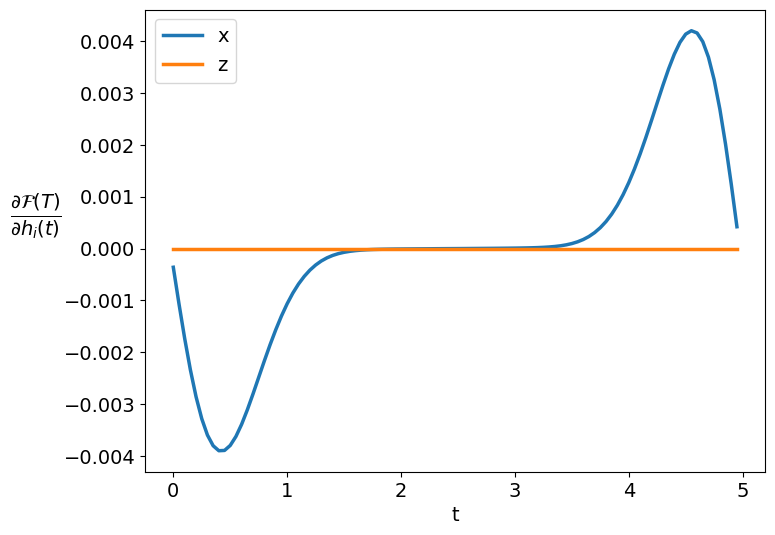

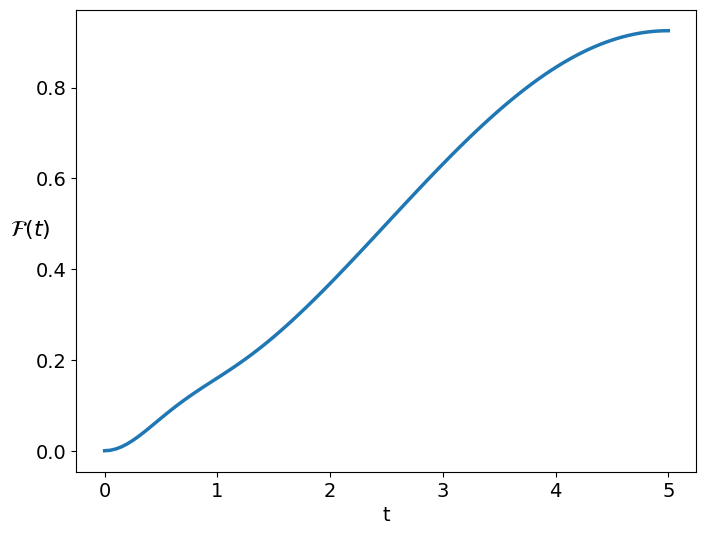

In [10]:
times_fidelity = [dt*x for x in range(0,num_steps+1)]
times_gradient = times_fidelity[:-1]

# Plot derivatives at each time
x_derivs , z_derivs = zip(*gradients.real)
plt.figure()

plt.plot(times_gradient,x_derivs,label='x')
plt.plot(times_gradient,z_derivs,label='z')

plt.legend()
plt.ylabel(r"$\frac{\partial \mathcal{F}(T)}{\partial h_i (t)}$",rotation=0,fontsize=20,labelpad=20)
plt.xlabel("t")
plt.show()

plt.figure()

hs_dim = 2

# Plot fidelities at each time
target_ndarray = target_derivative
target_ndarray = target_ndarray.reshape(hs_dim**2)

dynamics = gradient_dynamics['dynamics'] 
fidelitys=[]

for state in dynamics.states:
    v_state = state.reshape(hs_dim**2)
    fidelity=target_ndarray@v_state
    fidelitys.append(fidelity.real)

plt.plot(times_fidelity,fidelitys)
plt.ylabel(r"$\mathcal{F} (t)$",rotation=0,fontsize=16)
plt.xlabel("t")
plt.show()

Voilà, we have computed the gradient! We can easily plug in another set of system parameters and rerun the calculation to get the gradient for a different field. This is particularly useful for optimisation of the objective function because the long calculation of the process tensor is done only once. We can do lots of faster calculations of $Z$ and $\frac{\partial Z}{\partial c_a}$ for different system parameters until we find an 'optimal' (minima/maxima of $Z$ within some tolerance) set of controls. An example of this is shown in `examples/fidelity-gradient.py`.

In [11]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d


class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))

        return np.min(zs)

In [12]:
from scipy.optimize import minimize
import oqupy.operators as op

num_params=2
timesteps = dt*np.arange(0,num_steps)

def infidandgrad(paras):
    """""
    Take a numpy array [hx0, hz0, hx1, hz1, ...] over full timesteps and
    return the fidelity and gradient of the fidelity to the global target_derivative
    """

    # Reshape flat parameter list to form accepted by state_gradient: [[hx0,hz0],[hx1,hz1,]...]
    reshapedparas=np.array([i for i in (paras.reshape((-1,num_params))).tolist() for j in range(2)])

    gradient_dict=oqupy.state_gradient(system=system,
        initial_state=initial_state, 
        target_derivative=target_derivative,
        process_tensors=[process_tensor],
        parameters=reshapedparas,
        progress_type='silent')
    
    fs=gradient_dict['final_state']
    gps=gradient_dict['gradient']
    fidelity=np.sum(fs*target_derivative.T)

    # Adding adjacent elements
    for i in range(0,gps.shape[0],2): 
        gps[i,:]=gps[i,:]+gps[i+1,:]
        
    gps=gps[0::2]

    # Return the minus the gradient as infidelity is being minimized 
    return 1-fidelity.real,(-1.0*gps.reshape((-1)).real).tolist()

# Set upper and lower bounds on control parameters
x_bound = [-5*np.pi,5*np.pi]
z_bound = [-np.pi,np.pi]

bounds = np.zeros((num_steps*num_params,2))

for i in range(0, num_params*num_steps,num_params):
        bounds[i] = x_bound
        bounds[i+1] = z_bound

z0 = np.ones(num_steps) * (np.pi) / (2*dt*num_steps)
x0 = np.zeros(num_steps)

# Flatten list for input to optimizer
parameter_list=np.array([item for pair in zip(x0, z0) for item in pair])

optimization_result = minimize(
                        fun=infidandgrad,
                        x0=parameter_list,
                        method='L-BFGS-B',
                        jac=True,
                        bounds=bounds,
                        options = {'disp':True, 'gtol': 7e-05}
)

print("The maximal fidelity was found to be : ",1-optimization_result.fun)

print("The Jacobian was found to be : ",optimization_result.jac)

optimized_params = optimization_result.x
reshapedparas=np.array([i for i in (optimized_params.reshape((-1,num_params))).tolist() for j in range(2)])

# Input optimized controls into state_gradient to show dynamics of system under optimized fields
optimized_dynamics = oqupy.state_gradient(
        system=system,
        initial_state=initial_state,
        target_derivative=target_derivative,
        process_tensors=[process_tensor],
        parameters=reshapedparas)

t, bloch_x =optimized_dynamics['dynamics'].expectations(op.sigma("x"))
t, bloch_y = optimized_dynamics['dynamics'].expectations(op.sigma("y"))
t, bloch_z = optimized_dynamics['dynamics'].expectations(op.sigma("z"))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          200     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.47500D-02    |proj g|=  4.19912D-03

At iterate    1    f=  7.44011D-02    |proj g|=  4.18187D-03

At iterate    2    f=  6.77711D-02    |proj g|=  7.60141D-03

At iterate    3    f=  4.31068D-02    |proj g|=  8.75070D-03

At iterate    4    f=  3.56271D-02    |proj g|=  1.62766D-03

At iterate    5    f=  3.39389D-02    |proj g|=  1.29585D-03

At iterate    6    f=  3.18419D-02    |proj g|=  1.04845D-03

At iterate    7    f=  3.13416D-02    |proj g|=  2.20839D-03

At iterate    8    f=  2.95084D-02    |proj g|=  1.54925D-03

At iterate    9    f=  2.69889D-02    |proj g|=  1.52174D-03

At iterate   10    f=  2.48968D-02    |proj g|=  9.12765D-04

At iterate   11    f=  2.40168D-02    |proj g|=  6.79408D-04

At iterate   12    f=  2.30611D-02    |proj g|=  6.31017D-04

At iterate   13    f=  2.0

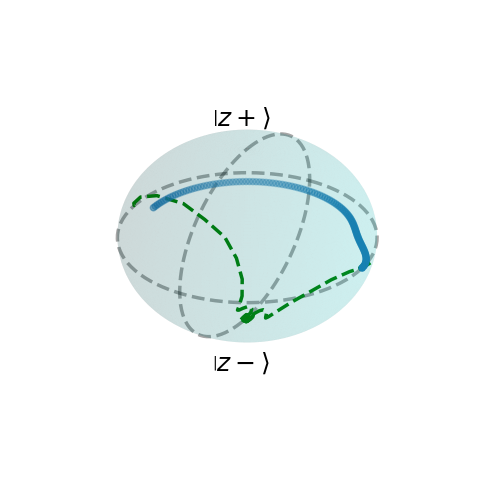

In [13]:

target_axis = [np.trace(target_derivative.T@op.sigma(i)) for i in ['x','y','z']]

fig=plt.figure()
t,x0 = dynamics.expectations(op.sigma('x'))
t,y0 = dynamics.expectations(op.sigma('y'))
t,z0 = dynamics.expectations(op.sigma('z'))
ax = fig.add_subplot(111, projection='3d')
arrow = Arrow3D([0,x0[0].real], [0,y0[0].real], [0,z0[0].real],mutation_scale=20, 
                lw=3, arrowstyle="-|>", color="r")

ax.text2D(0.5, 0.75,r'$\left|{z+}\right\rangle$', fontsize=18, ha='center', transform=ax.transAxes)
ax.text2D(0.5, 0.22,r'$\left|{z-}\right\rangle$', fontsize=18, ha='center', transform=ax.transAxes)

theta1, phi1 = np.linspace(0, 2 * np.pi, 100), np.linspace(0, np.pi, 100)
theta, phi = np.meshgrid(theta1, phi1)
r = 1
x = r * np.sin(phi) * np.cos(theta1)
y = r * np.sin(phi) * np.sin(theta1)
z = r * np.cos(phi)

plt.axis('off')

z1 = np.zeros(100)
x1 = r * np.sin(theta1)
y1 = r * np.cos(theta1)

ax.plot(x1, y1, z1, color='black', alpha=0.35,linestyle='--')
ax.plot(z1, x1, y1, color='black', alpha=0.35,linestyle='--')
ax.plot(bloch_x.real,bloch_y.real,bloch_z.real,c='g',linestyle='--',label='optimised dynamics')

ax.plot_surface(
    x, y, z,  rstride=1, cstride=1, color='c', alpha=0.1, linewidth=0)
ax.scatter(x0.real,y0.real,z0.real)


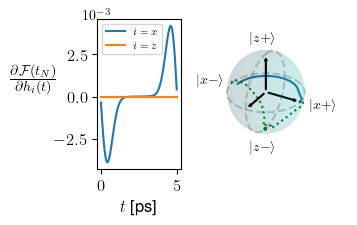

In [158]:
target_axis = [np.trace(target_derivative.T@op.sigma(i)) for i in ['x','y','z']]

fig,axes=plt.subplots(1,2,figsize=(10,10),width_ratios=[1,2])
axes[0].axis('off')
axes[1].axis('off')

t,x0 = dynamics.expectations(op.sigma('x'))
t,y0 = dynamics.expectations(op.sigma('y'))
t,z0 = dynamics.expectations(op.sigma('z'))
ax = fig.add_subplot(122, projection='3d')
arrow = Arrow3D([0,0], [0,0], [0,1],mutation_scale=3, 
                lw=1.5, arrowstyle="-|>", color="black")
ax.add_artist(arrow)
arrow = Arrow3D([0,0], [0,-1], [0,0],mutation_scale=3, 
                lw=1.5, arrowstyle="-|>", color="black")
ax.add_artist(arrow)
arrow = Arrow3D([0,1], [0,0], [0,0],mutation_scale=3, 
                lw=1.5, arrowstyle="-|>", color="black")
ax.add_artist(arrow)
#
ax.text2D(0.5, 0.85,r'$\left| {z+} \right\rangle$', fontsize=10, ha='center', transform=ax.transAxes)
ax.text2D(0.5, 0.12,r'$\left| {z-} \right\rangle$', fontsize=10, ha='center', transform=ax.transAxes)
ax.text2D(0.15, 0.57,r'$\left| {x-} \right\rangle$', fontsize=10, ha='center', transform=ax.transAxes)
ax.text2D(0.9, 0.4,r'$\left| {x+} \right\rangle$', fontsize=10, ha='center', transform=ax.transAxes)

#ax.text2D(-0.5, 0.9,r'(b)', fontsize=16, ha='center', transform=ax.transAxes)

theta1, phi1 = np.linspace(0, 2 * np.pi, 100), np.linspace(0, np.pi, 100)
theta, phi = np.meshgrid(theta1, phi1)
r = 1
x = r * np.sin(phi) * np.cos(theta1)
y = r * np.sin(phi) * np.sin(theta1)
z = r * np.cos(phi)

plt.axis('off')

z1 = np.zeros(100)
x1 = r * np.sin(theta1)
y1 = r * np.cos(theta1)

ax.plot(x1, y1, z1, color='black', alpha=0.2,linestyle='--')
ax.plot(z1, x1, y1, color='black', alpha=0.2,linestyle='--')

ax.plot_surface(
    x, y, z,  rstride=1, cstride=1, color='c', alpha=0.1, linewidth=0)
ax.plot(x0.real,y0.real,z0.real,label='initial dynamics')
ax.plot(bloch_x.real,bloch_y.real,bloch_z.real,c='g',linestyle=':',label='optimised dynamics')
#ax.legend(loc=(-0.6,0.15),fontsize=11)
ax.set_box_aspect((np.ptp(x), np.ptp(y), np.ptp(z)))

ax2 = fig.add_subplot(121)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='minor', labelsize=12)
ax2.plot(times_gradient,np.array(x_derivs)*1000,label=r'$i=x$')
ax2.plot(times_gradient,np.array(z_derivs)*1000,label=r'$i=z$')

ax2.legend(loc='upper left',fontsize=7)
ax2.set_ylabel(r"$\frac{\partial \mathcal{F}(t_N)}{\partial h_i (t)}$",rotation=0,fontsize=14,labelpad=15)
ax2.set_xlabel(r"$t$ [ps]",rotation=0,fontsize=12)

#ax2.text(-2.9, 3.6, '(a)', fontsize = 12)
ax2.text(-1.2, 4.6, r'$10^{-3}$', fontsize = 10)
fig.tight_layout()
fig.subplots_adjust(top=1,bottom=0,right=1,left=0,hspace=0,wspace=0)
fig.set_size_inches(w=2.5, h=1.5)
plt.savefig('gradient.pdf',dpi=300, bbox_inches = "tight")
plt.show()


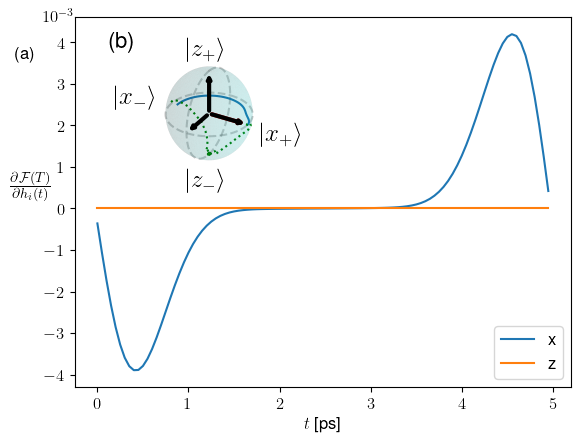

In [81]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
    "text.usetex":True,
    "font.family":"sans-serif",
    "font.sans-serif":"Helvetica",
})

fig = plt.figure()
ax2=fig.add_subplot(111)

ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='minor', labelsize=12)
ax2.plot(times_gradient,np.array(x_derivs)*1000,label='x')
ax2.plot(times_gradient,np.array(z_derivs)*1000,label='z')

ax2.legend(loc='lower right',fontsize=12)
ax2.set_ylabel(r"$\frac{\partial \mathcal{F}(T)}{\partial h_i (t)}$",rotation=0,fontsize=14,labelpad=10)
ax2.set_xlabel(r"$t$ [ps]",rotation=0,fontsize=12)
ax2.text(-0.9, 3.6, '(a)', fontsize = 12)
ax2.text(-0.6, 4.5, r'$10^{-3}$', fontsize = 12)
#ax2.text(4.4, -5.8, 't [ps]', fontsize = 12)


target_axis = [np.trace(target_derivative.T@op.sigma(i)) for i in ['x','y','z']]

t,x0 = dynamics.expectations(op.sigma('x'))
t,y0 = dynamics.expectations(op.sigma('y'))
t,z0 = dynamics.expectations(op.sigma('z'))

rect=[0.2,0.5,0.35,0.35]
ax = fig.add_axes(rect,anchor='NW',projection='3d')
arrow = Arrow3D([0,x0[0].real], [0,y0[0].real], [0,z0[0].real],mutation_scale=5, 
                lw=3, arrowstyle="-|>", color="r")
ax.add_artist(arrow)
arrow = Arrow3D([0,0], [0,0], [0,1],mutation_scale=5, 
                lw=3, arrowstyle="-|>", color="black")
ax.add_artist(arrow)
arrow = Arrow3D([0,0], [0,-1], [0,0],mutation_scale=5, 
                lw=3, arrowstyle="-|>", color="black")
ax.add_artist(arrow)
arrow = Arrow3D([0,1], [0,0], [0,0],mutation_scale=5, 
                lw=3, arrowstyle="-|>", color="black")
ax.add_artist(arrow)
#
ax.text2D(0.5, 0.86,r'$| {z_+} \rangle$', fontsize=18, ha='center', transform=ax.transAxes)
ax.text2D(0.5, 0.08,r'$\left| {z_-} \right\rangle$', fontsize=18, ha='center', transform=ax.transAxes)
ax.text2D(0.08, 0.57,r'$\left| {x_-} \right\rangle$', fontsize=18, ha='center', transform=ax.transAxes)
ax.text2D(0.95, 0.35,r'$\left| {x_+} \right\rangle$', fontsize=18, ha='center', transform=ax.transAxes)

ax.text2D(-0.0, 0.9,r'(b)', fontsize=16, ha='center', transform=ax.transAxes)

theta1, phi1 = np.linspace(0, 2 * np.pi, 100), np.linspace(0, np.pi, 100)
theta, phi = np.meshgrid(theta1, phi1)
r = 1
x = r * np.sin(phi) * np.cos(theta1)
y = r * np.sin(phi) * np.sin(theta1)
z = r * np.cos(phi)

plt.axis('off')
z1 = np.zeros(100)
x1 = r * np.sin(theta1)
y1 = r * np.cos(theta1)

ax.plot(x1, y1, z1, color='black', alpha=0.2,linestyle='--')
ax.plot(z1, x1, y1, color='black', alpha=0.2,linestyle='--')

ax.plot_surface(
    x, y, z,  rstride=1, cstride=1, color='c', alpha=0.1, linewidth=0)
ax.plot(x0.real,y0.real,z0.real,label='initial dynamics')
ax.plot(bloch_x.real,bloch_y.real,bloch_z.real,c='g',linestyle=':',label='optimised dynamics')
#ax.legend(loc=(-0.6,0.15),fontsize=11)
ax.set_box_aspect((np.ptp(x), np.ptp(y), np.ptp(z)))
plt.show()

fig.set_size_inches(w=2.5, h=5)